# PIT for Conditional Flows
Project idea based on [this paper](https://arxiv.org/abs/2102.10473). 

Using the `nflows` library for flow implementations.

## CONTEXT (1D)

Consider the 1D conditional target distribution $f_{\Theta\mid X}$ with **unknown density** and we have **no samples**.

We only have access to samples from the joint distribution $f_{X,\Theta}$: $\quad (\Theta_1,X_1), \dots, (\Theta_n, X_n) \sim f_{X,\Theta}$

Our estimator $f_{Q\mid X}$ is a *Normalizing Flow* whose density is **explicitly known**. It is defined by a base distribution $p_U$ (tipically gaussian) and a bijective transformation $T_{\phi}$: 
$$U\sim p_U \rightarrow Q=T_{\phi}(U, X) \sim f_{Q\mid X}$$ 
$$f_{Q\mid X}(q) = p_{U}\left(T_{\phi}^{-1}(q, X)\right)\left|\operatorname{det} J_{T_{\phi}^{-1}}(q, X)\right|$$ 

Note that we can also define it's c.d.f. explicitly for a fixed $X=x_0$: $\quad F_{Q\mid X=x_0}(q) = \mathbb{P}(Q\leq q \mid X=x_0) =\mathbb{P}(T_{\phi}(U, x_0)\leq q)=\mathbb{P}(U\leq T_{\phi}^{-1}(q, x_0))=F_U(T_{\phi}^{-1}(q, x_0))$

We wish to know evaluate our estimator, with the same method as in the non-conditional case, i.e. with the PIT:

$$\text{PIT}(\theta, x ; f_{Q\mid X}) = \mathbb{P}(Q\leq \theta \mid X=x) = F_{Q \mid X=x}(\theta)$$

## EVALUATION
### True PIT-distribution / Local Consistency
For a fixed $X = x_0$ and $\Theta \sim f_{\Theta \mid X=x_0}$:
$$\begin{align} 
f_{Q\mid x_0} = f_{\Theta\mid x_0} & \iff \text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \sim \mathcal{U}(0,1)\\
& \iff \mathbb{P}_{\Theta \mid x_0}(\text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \leq \alpha) = \alpha, \quad \forall \alpha \in [0,1]\\
& \iff F_{\Theta \mid X=x_0}(F_{Q \mid X=x_0}^{-1}(\alpha)) = \alpha, \quad \forall \alpha \in [0,1]
\end{align}$$

We find ourselves with the same result as in the non-conditional 1D case , as $X$ is fixed at $x_0$ (cf. Theorem 2 in paper). 

**Problem:** We are unable to compute the c.d.f. of the target distribution $F_{\Theta \mid X=x_0}$, as the density $f_{\Theta \mid x_0}$ is unknown and no samples $\theta_i \mid x_0$ are available to approximate it empirically.

### Expected PIT-distribution over $X$ / Global Consistency 
We can however compute the empirical **expected c.d.f. over $X$** by using the samples from the joint distribution. 

$$\begin{align}
\mathbb{E}_X[F_{\Theta\mid X}(F_{Q\mid X}(\alpha)^{-1})] & = \mathbb{E}_X[\mathbb{P}_{\Theta\mid X}(F_{Q\mid X}(\Theta)\leq \alpha)]\\
& = \mathbb{E}_X[\mathbb{E}_{\Theta\mid X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]]\\
& = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]\\
& \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}
\end{align}$$

This gives us an approximation of the **expected (or joint) PIT-distribution:** 

$$\mathbb{E}_X[\mathbb{P}_{\Theta \mid x_0}(\text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \leq \alpha)] = \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}$$

#### Result 1: 
It is still true that if $f_{Q\mid X} = f_{\Theta\mid X} \forall X$ (global consistency) and $\Theta, X \sim f_{\Theta, X}$, the *joint PIT-distribution* is uniform:

$$f_{Q\mid X} = f_{\Theta\mid X} \Rightarrow \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) =\alpha, \quad \forall \alpha \in [0,1]$$

**Problem:** The reverse is not true! This quantity does not allow us to evaluate our estimator (i.e. check global concistency) in a reliable way: we can find globally non-consistent estimators ($f_{Q\mid X} \neq f_{\Theta\mid X}$), but whose joint PIT-distribution is uniform. 

#### Result 2: 
Uniformity of the expected PIT-distribution holds for any estimator $f_{Q\mid X} = f_{\Theta\mid g(X)}$ with $g$ a given function (cf. Theorem 1 in paper).

#### Proofs

### Illustration via Code 

Let's look at some code to illustrate this.

We consider a target density $\Theta\mid X \sim \mathcal{N}(X_1+X_2, 1)$ with $X = (X_1, X_2) \sim \mathcal{N}(\mu, \Sigma)$ where $\mu = [\mu_1, \mu_2]$ and $\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho \sigma_1 \sigma_2\\ \rho \sigma_1 \sigma_2 & \sigma_{2}^2 \end{pmatrix}$.



In [105]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.distributions as D
from scipy.stats import multivariate_normal, norm

from nde.train import train
from nde.flows import construct_maf
from plot import plot_pdf_1D

# Distribution parameters
mu_1 = 0
mu_2 = 0
sigma_1 = 1
sigma_2 = 1
rho = 0.8

# Distribution of X: 2d gaussian
mean = np.array([mu_1,mu_2])
covariance = np.array([[sigma_1**2, rho*sigma_1*sigma_2],[rho*sigma_1*sigma_2, sigma_2**2]])
x_dist = multivariate_normal(mean=mean, cov=covariance)

# Samples from the conditional distribution P(Theta|X)
n = 2_000 # nb samples 
samples_x = x_dist.rvs(n) # samples from P(X)
samples_theta = np.array([norm(loc = x[0]+x[1], scale=1).rvs(1) for x in samples_x]) # samples from P(Theta|X)


#### Result 1: Uniformity of the expected PIT-distribution

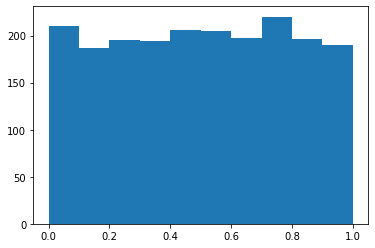

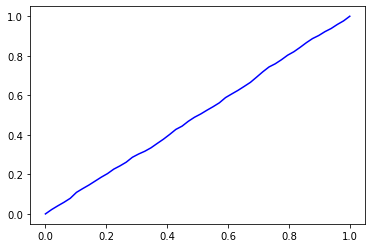

In [106]:
# Plot expected PIT-distribution
Z = np.array(np.mean([norm.cdf(samples_theta, loc=x[0]+x[1], scale=1) for x in samples_x], axis=0)) # E_X[PIT(Theta, X, f_{Theta|X})]
plt.hist(Z)
plt.show()

# Plot pp_plot
alphas = np.linspace(0,1)
z_true = [np.mean(Z[:,0] < alpha) for alpha in alphas]
plt.plot(alphas, z_true, color='blue')
plt.show()

#### Result 2: Uniformity of globally non-consistent estimators
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

In [107]:
# Get train and test samples: 
# - train samples are used to train the flow, 
# - test samples are used to compute the empiriacal r(alpha).

samples_x, samples_theta = torch.FloatTensor(samples_x), torch.FloatTensor(samples_theta)
test_size = int(0.1* len(samples_theta))
train_size = len(samples_theta) - test_size
x_train, x_test = samples_x[:train_size], samples_x[train_size:]
theta_train, theta_test = samples_theta[:train_size], samples_theta[train_size:]
print('NB training samples: ', x_train.shape)
print('NB test samples: ', x_test.shape)

# Good MAF trained on X=(X_1,X_2)
maf_good = construct_maf(theta_train, hidden_features=50, context_features=2, standardize_transform=False)
best_val_loss_good, epochs_good = train(maf_good, theta_train, context=x_train, num_epochs=2000, batch_size=10, lr=0.005, validation=True, plot=False, epochs_until_converge=20)

# Bad MAF trained on g(X)=(X_1)
maf_bad = construct_maf(theta_train, hidden_features=50, context_features=1, standardize_transform=False)
best_val_loss_bad, epochs_bad = train(maf_bad, theta_train, context=x_train[:,0].reshape(-1,1), num_epochs=2000, batch_size=10, lr=0.005, validation=True, plot=False, epochs_until_converge=20)

NB training samples:  torch.Size([1800, 2])
NB test samples:  torch.Size([200, 2])


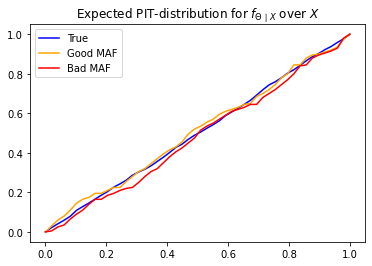

In [115]:
# expected PIT-distribution
cdf_flow = lambda x,context,flow: D.Normal(0,1).cdf(flow._transform(x, context=context)[0])
Z_maf_good = np.mean([cdf_flow(theta_test, context=x, flow=maf_good).detach().numpy() for x in x_test], axis=0) # E_X[PIT(Theta, X, good]
Z_maf_bad = np.mean([cdf_flow(theta_test, context=x, flow=maf_bad).detach().numpy() for x in x_test[:,0].reshape(-1,1)], axis=0) # E_X[PIT(Theta, X, bad]

# Plot pp_plot
alphas = np.linspace(0,1)
z_maf_good = [np.mean(Z_maf_good[:,0] < alpha) for alpha in alphas]
z_maf_bad = [np.mean(Z_maf_bad[:,0] < alpha) for alpha in alphas]

plt.plot(alphas, z_true, color='blue', label='True')
plt.plot(alphas, z_maf_good, color='orange', label='Good MAF')
plt.plot(alphas, z_maf_bad, color='red', label='Bad MAF')
plt.legend()
plt.title(r'Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$')
plt.show()

Both estimators have uniform PIT-distribution, but the bad MAF is not globally consistent. 

Indeed, the code below will show that the bad MAF is locally inconsistent, which implies also that it cannot be globally consistent.

In [109]:
# Samples from the conditional distribution Theta|X=X_0
x_0 = x_test[0][None,:]
n = 2_000 # nb samples 
samples_theta_x = torch.FloatTensor(norm(loc = x_0[:,0]+x_0[:,1], scale=1).rvs(2_000)).reshape(-1,1) # samples from P(Theta|X=x_0)
x_0

tensor([[-0.4535, -0.2953]])

Text(0.5, 1.0, 'Local PIT-distribution for $f_{\\Theta \\mid X=x_0}$')

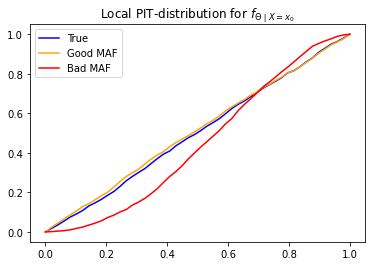

In [116]:
# expected PIT-distribution
Z_x = norm.cdf(samples_theta_x, loc=x_0[:,0]+x_0[:,1], scale=1) # E_X[PIT(Theta, X, f_{Theta|X})]
Z_maf_good_x = cdf_flow(samples_theta_x, context=x_0, flow=maf_good).detach().numpy() # E_X[PIT(Theta, X=x_0, good]
Z_maf_bad_x = cdf_flow(samples_theta_x, context=x_0[:,0], flow=maf_bad).detach().numpy() # E_X[PIT(Theta, X=x_0, bad]

# Plot pp_plot
alphas = np.linspace(0,1)
z_true_x = [np.mean(Z_x[:,0] < alpha) for alpha in alphas]
z_maf_good_x = [np.mean(Z_maf_good_x[:,0] < alpha) for alpha in alphas]
z_maf_bad_x = [np.mean(Z_maf_bad_x[:,0] < alpha) for alpha in alphas]

plt.plot(alphas, z_true_x, color='blue', label='True')
plt.plot(alphas, z_maf_good_x, color='orange', label='Good MAF')
plt.plot(alphas, z_maf_bad_x, color='red', label='Bad MAF')
plt.legend()
plt.title(r'Local PIT-distribution for $f_{\Theta \mid X=x_0}$')

This shows that if our function $g(X)$ doas not caracterize covariate relations between the elements of $X$ (e.g. non-sufficient summary statistics), the expected PIT-distribution will not show us the error, whereas the local PIT-distribution would have.

We need a way to claculate the local PIT-distribution! 